In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
from torch.utils.data.dataloader import DataLoader
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [97]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
                        
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            
            nn.Linear(32, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Params state and actions are torch tensors
        """
        
        return self.layers(x)


In [102]:
prefix = 'doubleInvertedPendulum'
states = np.load(prefix + 'Dataset/states_array.npy')
actions = np.load(prefix + 'Dataset/actions_array.npy')
rewards = np.load(prefix + 'Dataset/rewards_array.npy')
next_states = np.load(prefix + 'Dataset/next_states_array.npy')
dones = np.load(prefix + 'Dataset/dones_array.npy')

In [103]:
X = np.concatenate((states, next_states), -1)
Y = actions

In [104]:
permutation = np.random.permutation(X.shape[0])
X = X[permutation]
X_test = torch.from_numpy(X[:100000]).float().to(device)
X_train = torch.from_numpy(X[100000:]).float().to(device)
Y = Y[permutation]
Y_test = torch.from_numpy(Y[:100000]).float().to(device)
Y_train = torch.from_numpy(Y[100000:]).float().to(device)

In [105]:
X_mean = torch.mean(X_train)
X_std = torch.std(X_train)
X_train -= X_mean
X_train /= X_std
X_test -= X_mean
X_test /= X_std

In [106]:
lr = 1e-2
batch_size = 4096
numBatches = int(np.ceil(X_train.shape[0] / batch_size))

In [107]:
model = MLP(X_train.shape[1], Y_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
criterion  = nn.L1Loss()

In [108]:
trainLosses = []
testLosses = []
learningRates = []
for epoch in range(400):
    t0 = time.time()
    permutation = np.random.permutation(X_train.shape[0])
    X_train = X_train[permutation]
    Y_train = Y_train[permutation]
    
    epochLoss = 0
    for batch in range(numBatches):
        x = X_train[batch * batch_size:(batch+1)*batch_size]
        y = Y_train[batch * batch_size:(batch+1)*batch_size]
        
        y_hat = model.forward(x)
        
        loss = criterion(y, y_hat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epochLoss += loss.item()
    
    finalEpochLoss = epochLoss / numBatches
    
    delta_t = time.time() - t0
    
    lr_scheduler.step()
    
    y_hat = model.forward(X_test)
    loss = criterion(Y_test, y_hat)
    
    testLoss = loss.item()
    
    testLosses.append(testLoss)
    learningRates.append(lr_scheduler.get_last_lr())
    trainLosses.append(finalEpochLoss)
    
    print('Epoch {} in time {}s || Training Loss {} || Testing Loss {}'.format(
        epoch+1, round(delta_t, 2), np.round(np.log10(finalEpochLoss), 3), np.round(np.log10(testLoss), 3)))

Epoch 1 in time 0.72s || Training Loss -1.09 || Testing Loss -1.159
Epoch 2 in time 0.67s || Training Loss -1.451 || Testing Loss -1.362
Epoch 3 in time 0.7s || Training Loss -1.551 || Testing Loss -1.489
Epoch 4 in time 0.72s || Training Loss -1.625 || Testing Loss -1.725
Epoch 5 in time 0.71s || Training Loss -1.643 || Testing Loss -1.767
Epoch 6 in time 0.66s || Training Loss -1.822 || Testing Loss -1.898
Epoch 7 in time 0.64s || Training Loss -1.751 || Testing Loss -1.45
Epoch 8 in time 0.64s || Training Loss -1.788 || Testing Loss -1.853
Epoch 9 in time 0.64s || Training Loss -1.775 || Testing Loss -1.48
Epoch 10 in time 0.64s || Training Loss -1.831 || Testing Loss -1.662
Epoch 11 in time 0.64s || Training Loss -1.686 || Testing Loss -2.057
Epoch 12 in time 0.64s || Training Loss -2.018 || Testing Loss -2.188
Epoch 13 in time 0.64s || Training Loss -1.977 || Testing Loss -1.925
Epoch 14 in time 0.67s || Training Loss -1.82 || Testing Loss -1.876
Epoch 15 in time 0.64s || Training

Epoch 119 in time 0.7s || Training Loss -3.207 || Testing Loss -3.284
Epoch 120 in time 0.81s || Training Loss -3.101 || Testing Loss -3.177
Epoch 121 in time 0.91s || Training Loss -3.297 || Testing Loss -3.033
Epoch 122 in time 0.93s || Training Loss -3.337 || Testing Loss -3.374
Epoch 123 in time 0.73s || Training Loss -3.269 || Testing Loss -3.058
Epoch 124 in time 0.72s || Training Loss -3.21 || Testing Loss -2.867
Epoch 125 in time 0.68s || Training Loss -3.087 || Testing Loss -3.221
Epoch 126 in time 0.73s || Training Loss -3.145 || Testing Loss -3.008
Epoch 127 in time 0.7s || Training Loss -3.239 || Testing Loss -3.31
Epoch 128 in time 0.69s || Training Loss -3.13 || Testing Loss -3.352
Epoch 129 in time 0.7s || Training Loss -3.085 || Testing Loss -2.894
Epoch 130 in time 0.79s || Training Loss -3.19 || Testing Loss -3.098
Epoch 131 in time 0.87s || Training Loss -3.189 || Testing Loss -3.305
Epoch 132 in time 0.76s || Training Loss -3.255 || Testing Loss -3.184
Epoch 133 in 

Epoch 235 in time 0.7s || Training Loss -3.51 || Testing Loss -3.418
Epoch 236 in time 0.71s || Training Loss -3.506 || Testing Loss -3.462
Epoch 237 in time 0.7s || Training Loss -3.505 || Testing Loss -3.463
Epoch 238 in time 0.7s || Training Loss -3.513 || Testing Loss -3.44
Epoch 239 in time 0.83s || Training Loss -3.513 || Testing Loss -3.437
Epoch 240 in time 0.94s || Training Loss -3.508 || Testing Loss -3.462
Epoch 241 in time 0.71s || Training Loss -3.513 || Testing Loss -3.389
Epoch 242 in time 0.7s || Training Loss -3.514 || Testing Loss -3.459
Epoch 243 in time 0.69s || Training Loss -3.516 || Testing Loss -3.463
Epoch 244 in time 0.72s || Training Loss -3.52 || Testing Loss -3.467
Epoch 245 in time 0.74s || Training Loss -3.517 || Testing Loss -3.433
Epoch 246 in time 0.72s || Training Loss -3.513 || Testing Loss -3.47
Epoch 247 in time 0.69s || Training Loss -3.513 || Testing Loss -3.466
Epoch 248 in time 0.75s || Training Loss -3.517 || Testing Loss -3.467
Epoch 249 in t

Epoch 352 in time 0.78s || Training Loss -3.576 || Testing Loss -3.506
Epoch 353 in time 0.84s || Training Loss -3.576 || Testing Loss -3.505
Epoch 354 in time 0.87s || Training Loss -3.576 || Testing Loss -3.505
Epoch 355 in time 0.99s || Training Loss -3.573 || Testing Loss -3.506
Epoch 356 in time 0.86s || Training Loss -3.576 || Testing Loss -3.506
Epoch 357 in time 0.87s || Training Loss -3.575 || Testing Loss -3.502
Epoch 358 in time 0.79s || Training Loss -3.573 || Testing Loss -3.504
Epoch 359 in time 0.82s || Training Loss -3.576 || Testing Loss -3.506
Epoch 360 in time 0.86s || Training Loss -3.576 || Testing Loss -3.506
Epoch 361 in time 0.86s || Training Loss -3.576 || Testing Loss -3.506
Epoch 362 in time 0.84s || Training Loss -3.576 || Testing Loss -3.506
Epoch 363 in time 0.81s || Training Loss -3.575 || Testing Loss -3.5
Epoch 364 in time 0.85s || Training Loss -3.576 || Testing Loss -3.506
Epoch 365 in time 0.8s || Training Loss -3.576 || Testing Loss -3.506
Epoch 366

<IPython.core.display.Javascript object>


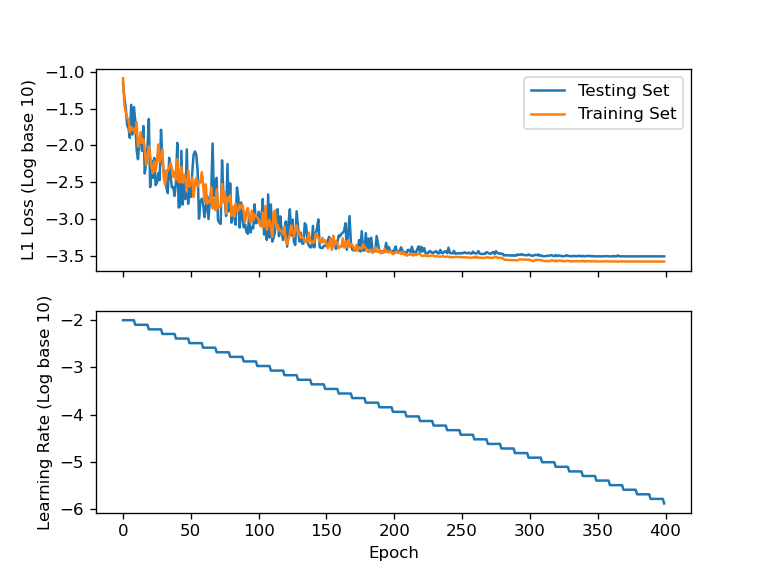

In [109]:
%matplotlib notebook
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(range(len(testLosses)), np.log10(testLosses))
ax[0].plot(range(len(trainLosses)), np.log10(trainLosses))
ax[0].set(ylabel='L1 Loss (Log base 10)')
ax[1].plot(range(len(learningRates)), np.log10(learningRates))
ax[1].set(ylabel='Learning Rate (Log base 10)')
ax[0].legend(["Testing Set", "Training Set"])
plt.xlabel('Epoch')
plt.show()
plt.savefig('trainingInverseDynamics-doublePendulum-MLP')

In [110]:
torch.save(model, 'inverseDynamics-doublePendlum-MLP.pt')